## Sources https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics/notebook

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from scipy import misc, ndimage
from skimage.morphology import reconstruction, disk
from skimage.filters import rank
from skimage import img_as_float, exposure

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = '../data/train/'
path_test = '../data/test/'

## Data Exploration

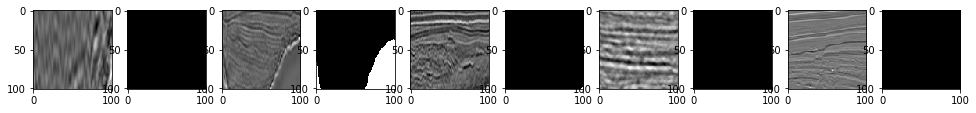

In [3]:
ids = ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20, 10))

for j, img_name in enumerate(ids):
    q = j+1
    img = load_img("../data/train/images/{}.png".format(img_name))
    img_mask = load_img("../data/train/masks/{}.png".format(img_name))
    
    plt.subplot(1, 2*(1+len(ids)), q*2-1)
    plt.imshow(img)
    plt.subplot(1, 2*(1+len(ids)), q*2)
    plt.imshow(img_mask)
plt.show()

## Define data augmentation function

In [9]:
def sharpening(img, alpha=20):
    blurred_f = ndimage.gaussian_filter(img, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    
    return sharpened

def edge_detection(img):
    im = ndimage.gaussian_filter(img, 1)
    sx = ndimage.sobel(im, axis=0, mode='constant')
    sy = ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    sob = np.array(sob, dtype=np.uint8)
    return sob

def mask_aug(img):
    mask = img > img.mean()
    label_im, _ = ndimage.label(mask)
    label_im = np.piecewise(label_im, [label_im < 1, label_im > 0], [0, 255])
    return np.array(label_im, dtype=np.uint8)

def filtering_regional_maxima(img):
    image = img_as_float(img)
    image = ndimage.gaussian_filter(image, 1)
    
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation') * 255
    return np.array(dilated, dtype=np.uint8)

def global_equalize(img):
    return np.array(exposure.equalize_hist(img) * 255, dtype=np.uint8)

def equalization(img):
    selem = disk(10)
    img_eq = rank.equalize(np.squeeze(img), selem=selem)
    return np.expand_dims(img_eq, -1)

def data_aug(img):
    return (sharpening(img), 
            edge_detection(img),
            mask_aug(img),
            filtering_regional_maxima(img), 
            global_equalize(img), 
            equalization(img))

## Fetch data

In [5]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+'images'))[2]

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)

X_train_sharpening = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_train_edge_detection = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_train_mask = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_train_filtering = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_train_global_equalize = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_train_equalization = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)


print('Getting and resizing train images and mask ...')
sys.stdout.flush()

for n, id_ in tqdm_notebook(enumerate(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    
    # Augmentation
    aug = data_aug(X_train[n])
    X_train_sharpening[n] = aug[0]
    X_train_edge_detection[n] = aug[1]
    X_train_mask[n] = aug[2]
    X_train_filtering[n] = aug[3]
    X_train_global_equalize[n] = aug[4]
    X_train_equalization[n] = aug[5]
    
    
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
print('Done!')

Getting and resizing train images and mask ...


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "



Done!


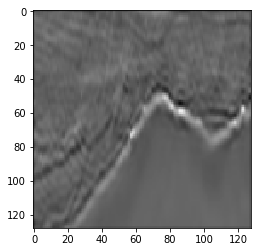

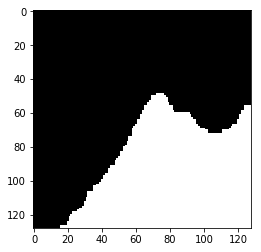

In [11]:
# Check if training data looks all right
ix = -1 #random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix], X_train[ix], X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

## Train Model

In [12]:
# Build U-Net Model
def create_model():
    inputs = Input((im_height, im_width, im_chan))
    s = Lambda(lambda x: x/255)(inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [16]:
def fit(model, X_train, Y_train, output_name):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('{}.h5'.format(output_name), verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=30, 
                        callbacks=[earlystopper, checkpointer])
    return results

### Normal fit

In [17]:
amodel = create_model()
fit(amodel, X_train, Y_train, 'model-tgs-salt-normal_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 7s 2ms/step - loss: 0.5779 - val_loss: 0.5178

Epoch 00001: val_loss improved from inf to 0.51785, saving model to model-tgs-salt-normal_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 799us/step - loss: 0.4497 - val_loss: 0.3964

Epoch 00002: val_loss improved from 0.51785 to 0.39635, saving model to model-tgs-salt-normal_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 831us/step - loss: 0.3733 - val_loss: 0.3494

Epoch 00003: val_loss improved from 0.39635 to 0.34944, saving model to model-tgs-salt-normal_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 829us/step - loss: 0.3369 - val_loss: 0.3914

Epoch 00004: val_loss did not improve from 0.34944
Epoch 5/30
3600/3600 [==============================] - 3s 850us/step - loss: 0.

In [18]:
amodel = create_model()
fit(amodel, X_train_sharpening, Y_train, 'model-tgs-salt-sharpening_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 4s 1ms/step - loss: 0.5800 - val_loss: 0.5637

Epoch 00001: val_loss improved from inf to 0.56366, saving model to model-tgs-salt-sharpening_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 819us/step - loss: 0.5580 - val_loss: 0.5619

Epoch 00002: val_loss improved from 0.56366 to 0.56186, saving model to model-tgs-salt-sharpening_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 831us/step - loss: 0.5554 - val_loss: 0.5599

Epoch 00003: val_loss improved from 0.56186 to 0.55986, saving model to model-tgs-salt-sharpening_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 842us/step - loss: 0.5251 - val_loss: 0.4503

Epoch 00004: val_loss improved from 0.55986 to 0.45032, saving model to model-tgs-salt-sharpening_validation_0.1_batch_

In [19]:
amodel = create_model()
fit(amodel, X_train_mask, Y_train, 'model-tgs-salt-mask_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 5s 1ms/step - loss: 0.5476 - val_loss: 0.4774

Epoch 00001: val_loss improved from inf to 0.47736, saving model to model-tgs-salt-mask_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 813us/step - loss: 0.4703 - val_loss: 0.4590

Epoch 00002: val_loss improved from 0.47736 to 0.45895, saving model to model-tgs-salt-mask_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 834us/step - loss: 0.4352 - val_loss: 0.4012

Epoch 00003: val_loss improved from 0.45895 to 0.40121, saving model to model-tgs-salt-mask_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 877us/step - loss: 0.4155 - val_loss: 0.3882

Epoch 00004: val_loss improved from 0.40121 to 0.38816, saving model to model-tgs-salt-mask_validation_0.1_batch_size_32_epochs_30.h5
Epo

In [20]:
amodel = create_model()
fit(amodel, X_train_global_equalize, Y_train, 'model-tgs-salt-global_equalize_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 5s 1ms/step - loss: 0.5322 - val_loss: 0.4556

Epoch 00001: val_loss improved from inf to 0.45556, saving model to model-tgs-salt-global_equalize_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 831us/step - loss: 0.4603 - val_loss: 0.4363

Epoch 00002: val_loss improved from 0.45556 to 0.43635, saving model to model-tgs-salt-global_equalize_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 851us/step - loss: 0.4244 - val_loss: 0.4276

Epoch 00003: val_loss improved from 0.43635 to 0.42755, saving model to model-tgs-salt-global_equalize_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 858us/step - loss: 0.4050 - val_loss: 0.3767

Epoch 00004: val_loss improved from 0.42755 to 0.37673, saving model to model-tgs-salt-global_equalize_v

In [21]:
amodel = create_model()
fit(amodel, X_train_filtering, Y_train, 'model-tgs-salt-filtering_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 5s 1ms/step - loss: 0.5751 - val_loss: 0.5662

Epoch 00001: val_loss improved from inf to 0.56617, saving model to model-tgs-salt-filtering_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 823us/step - loss: 0.5271 - val_loss: 0.4429

Epoch 00002: val_loss improved from 0.56617 to 0.44294, saving model to model-tgs-salt-filtering_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 848us/step - loss: 0.4154 - val_loss: 0.3809

Epoch 00003: val_loss improved from 0.44294 to 0.38090, saving model to model-tgs-salt-filtering_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 872us/step - loss: 0.3670 - val_loss: 0.3535

Epoch 00004: val_loss improved from 0.38090 to 0.35349, saving model to model-tgs-salt-filtering_validation_0.1_batch_size

In [22]:
amodel = create_model()
fit(amodel, X_train_equalization, Y_train, 'model-tgs-salt-equalization_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 5s 1ms/step - loss: 0.5404 - val_loss: 0.4533

Epoch 00001: val_loss improved from inf to 0.45330, saving model to model-tgs-salt-equalization_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 847us/step - loss: 0.4523 - val_loss: 0.4226

Epoch 00002: val_loss improved from 0.45330 to 0.42256, saving model to model-tgs-salt-equalization_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 871us/step - loss: 0.4333 - val_loss: 0.4158

Epoch 00003: val_loss improved from 0.42256 to 0.41576, saving model to model-tgs-salt-equalization_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 884us/step - loss: 0.4070 - val_loss: 0.3840

Epoch 00004: val_loss improved from 0.41576 to 0.38398, saving model to model-tgs-salt-equalization_validation_0.

In [23]:
amodel = create_model()
fit(amodel, X_train_edge_detection, Y_train, 'model-tgs-salt-edge_detection_validation_0.1_batch_size_32_epochs_30')

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 6s 2ms/step - loss: 0.5528 - val_loss: 0.5086

Epoch 00001: val_loss improved from inf to 0.50862, saving model to model-tgs-salt-edge_detection_validation_0.1_batch_size_32_epochs_30.h5
Epoch 2/30
3600/3600 [==============================] - 3s 850us/step - loss: 0.3837 - val_loss: 0.3407

Epoch 00002: val_loss improved from 0.50862 to 0.34067, saving model to model-tgs-salt-edge_detection_validation_0.1_batch_size_32_epochs_30.h5
Epoch 3/30
3600/3600 [==============================] - 3s 848us/step - loss: 0.3410 - val_loss: 0.3097

Epoch 00003: val_loss improved from 0.34067 to 0.30971, saving model to model-tgs-salt-edge_detection_validation_0.1_batch_size_32_epochs_30.h5
Epoch 4/30
3600/3600 [==============================] - 3s 868us/step - loss: 0.3299 - val_loss: 0.3712

Epoch 00004: val_loss did not improve from 0.30971
Epoch 5/30
3600/3600 [==============================] - 

### Compute weight for each prediction

In [42]:
val_loss_normal = 0.16529
val_loss_sharpening = 0.21629
val_loss_mask = 0.25449
val_loss_global_equalize = 0.17938
val_loss_filtering = 0.19507
val_loss_equalization = 0.23340
val_loss_edge_detection = 0.22884

all_val_loss = np.array([val_loss_normal, val_loss_global_equalize, val_loss_filtering])

In [30]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [43]:
1-all_val_loss**2

array([0.97267922, 0.96782282, 0.9619477 ])

In [69]:
models_weights = softmax(1-all_val_loss)
models_weights

array([0.33821858, 0.33348649, 0.32829493])

## Test weight

In [45]:
model_normal = load_model('model-tgs-salt-normal_validation_0.1_batch_size_32_epochs_30.h5')
model_global_eq = load_model('model-tgs-salt-global_equalize_validation_0.1_batch_size_32_epochs_30.h5')
model_filtering = load_model('model-tgs-salt-filtering_validation_0.1_batch_size_32_epochs_30.h5')

In [51]:
preds_train_normal = (model_normal.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) > 0.5).astype(np.uint8)
preds_train_global_eq = (model_global_eq.predict(X_train_global_equalize[int(X_train_global_equalize.shape[0]*0.9):], verbose=1) > 0.5).astype(np.uint8)
preds_train_filtering = (model_filtering.predict(X_train_filtering[int(X_train_filtering.shape[0]*0.9):], verbose=1) > 0.5).astype(np.uint8)

400/400 [==============================] - 0s 352us/step


3600

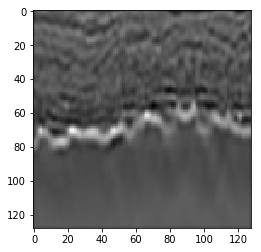

Y


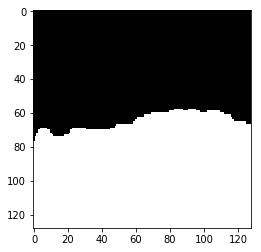

Normal


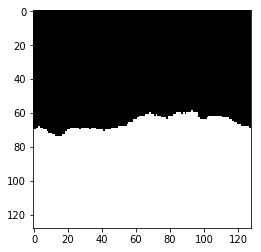

Global


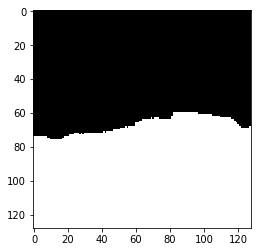

Filtering


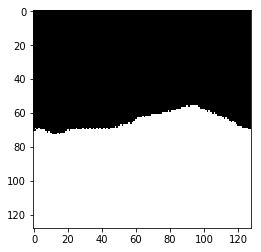

Combine


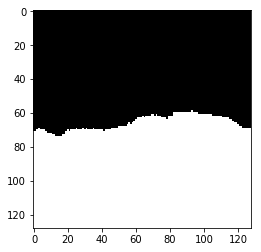

In [68]:
ix = int(X_train.shape[0]*0.9)
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show();

print('Y')
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)));
plt.show()

print('Normal')
tmpn = np.squeeze(preds_train_normal[0]).astype(np.float32)
plt.imshow(np.dstack((tmpn,tmpn,tmpn)));
plt.show()

print('Global')
tmpg = np.squeeze(preds_train_global_eq[0]).astype(np.float32)
plt.imshow(np.dstack((tmpg,tmpg,tmpg)));
plt.show()

print('Filtering')
tmpf = np.squeeze(preds_train_filtering[0]).astype(np.float32)
plt.imshow(np.dstack((tmpf,tmpf,tmpf)));
plt.show()

print('Combine')
tmpA = tmpn*0.33821858+tmpg*0.33348649+tmpf*0.32829493
tmpA = np.piecewise(tmpA, [tmpA < 0.6, tmpA >= 0.6], [0, 1])
plt.imshow(np.dstack((tmpA, tmpA, tmpA)));

## Test Data

In [72]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)

X_test_filtering = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_test_global_equalize = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)


sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), ascii=True):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x
    
    # Augmentation
    aug = data_aug(X_test[n])
    X_test_filtering[n] = aug[3]
    X_test_global_equalize[n] = aug[4]

print('Done!')

Getting and resizing test images ... 


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "



Done!


In [73]:
preds_test_normal = (model_normal.predict(X_test, verbose=1) > 0.5).astype(np.uint8)
preds_test_global_eq = (model_global_eq.predict(X_test_global_equalize, verbose=1) > 0.5).astype(np.uint8)
preds_test_filtering = (model_filtering.predict(X_test_filtering, verbose=1) > 0.5).astype(np.uint8)

18000/18000 [==============================] - 6s 319us/step


In [75]:
preds_test = preds_test_normal * models_weights[0] + preds_test_global_eq * models_weights[1] * preds_test_filtering * models_weights[2]

In [79]:
np.unique(preds_test[0])

array([0.])

In [78]:
preds_test = np.piecewise(preds_test, [preds_test < 0.6, preds_test >= 0.6], [0, 1])

In [80]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [81]:
preds_test_upsampled[0].shape

(101, 101)

## Prepare Submission

In [82]:


def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [83]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')